In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Fungsi untuk mengurai XML Pascal VOC
def parse_voc_xml(xml_path):
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        objects.append((name,))
    return objects

# Fungsi untuk memuat dataset
def load_dataset(dataset_dir, subset):
    images = []
    labels = []
    label_map = {'document': 0, 'KTP': 1, 'KK': 2, 'SIM': 3}  # Pemetaan label ke angka
    folder_path = os.path.join(dataset_dir, subset)
    for file in os.listdir(folder_path):
        if file.endswith(".xml"):
            xml_path = os.path.join(folder_path, file)
            objects = parse_voc_xml(xml_path)
            if len(objects) > 0:  # Pastikan file XML memiliki objek
                image_name = file.replace(".xml", "") + ".jpg"  # Asumsi file gambar memiliki nama yang sama dengan file XML
                image_path = os.path.join(folder_path, image_name)
                if os.path.exists(image_path):
                    img = cv2.imread(image_path)
                    if img is not None:
                        img = cv2.resize(img, (256, 256))
                        images.append(img)
                        labels.append(label_map[objects[0][0]])  # Konversi label string ke angka
                    else:
                        print(f"[Warning] Gambar tidak dapat dibaca: {image_path}")
                else:
                    print(f"[Warning] Path gambar tidak ditemukan: {image_path}")
    return np.array(images), np.array(labels)

# Membuat model CNN
def create_model():
    input_layer = Input(shape=(256, 256, 3))
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(4, activation='softmax')(x)  # Sesuaikan jumlah kelas
    model = Model(inputs=input_layer, outputs=output, name="model_klasifikasi")
    return model

# Memuat dataset dari folder
dataset_dir = "./dataset"
X_train, y_train = load_dataset(dataset_dir, "train")
X_valid, y_valid = load_dataset(dataset_dir, "valid")
X_test, y_test = load_dataset(dataset_dir, "test")

# Konversi labels menjadi one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=4)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4)

# Memastikan dimensi dataset sebelum melatih
print("Shapes before training:")
print("X_train shape:", X_train.shape)  # Harus (batch_size, 256, 256, 3)
print("y_train shape:", y_train.shape)  # Harus (batch_size, num_classes)
print("X_valid shape:", X_valid.shape)  # Harus (batch_size, 256, 256, 3)
print("y_valid shape:", y_valid.shape)  # Harus (batch_size, num_classes)
print("X_test shape:", X_test.shape)   # Harus (batch_size, 256, 256, 3)
print("y_test shape:", y_test.shape)   # Harus (batch_size, num_classes)

# Membuat model
model = create_model()

# Menyusun model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

# Melatih model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=32)

# Mengevaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Shapes before training:
X_train shape: (665, 256, 256, 3)
y_train shape: (665, 4)
X_valid shape: (63, 256, 256, 3)
y_valid shape: (63, 4)
X_test shape: (15, 256, 256, 3)
y_test shape: (15, 4)


Model: "model_klasifikasi"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 516128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    66,064,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,065,924 (252.02 MB)

 Trainable params: 66,065,924 (252.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 990ms/step - accuracy: 0.3158 - loss: 13862.3506 - val_accuracy: 0.2698 - val_loss: 650.3393
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 988ms/step - accuracy: 0.3675 - loss: 389.3449 - val_accuracy: 0.5079 - val_loss: 106.3849
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 986ms/step - accuracy: 0.6763 - loss: 83.4345 - val_accuracy: 0.8413 - val_loss: 20.9771
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 981ms/step - accuracy: 0.8780 - loss: 6.5435 - val_accuracy: 0.8730 - val_loss: 5.5562
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 976ms/step - accuracy: 0.8805 - loss: 3.9908 - val_accuracy: 0.8095 - val_loss: 17.5012
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 982ms/step - accuracy: 0.9653 - loss: 1.2780 - val_accuracy: 0.8889 - val_loss: 4.5932
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 967ms/step - accuracy: 0.9781 - loss: 0.2196 - val_accuracy: 0.8889 - val_loss: 5.5605
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 980ms/step - accuracy: 0.9980 - loss: 0.02

In [52]:
# Menyimpan model ke file .h5
model.save('model_klasifikasi.h5')
print("Model saved to model_klasifikasi.h5")

Model saved to model_klasifikasi.h5


In [4]:
# Mengonversi model ke format .tflite
def save_tflite_model(model, output_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(output_path, 'wb') as f:
        f.write(tflite_model)
    print(f"Model berhasil disimpan sebagai {output_path}")

# Simpan model ke dalam file .tflite
save_tflite_model(model, "model_klasifikasi.tflite")

INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp7gaqinn3\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmp7gaqinn3\assets


Saved artifact at 'C:\Users\ACER\AppData\Local\Temp\tmp7gaqinn3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_6')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2494059051728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2494059050768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2494910318544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2494910319888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2494910318736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2494910331216: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil disimpan sebagai model_klasifikasi.tflite


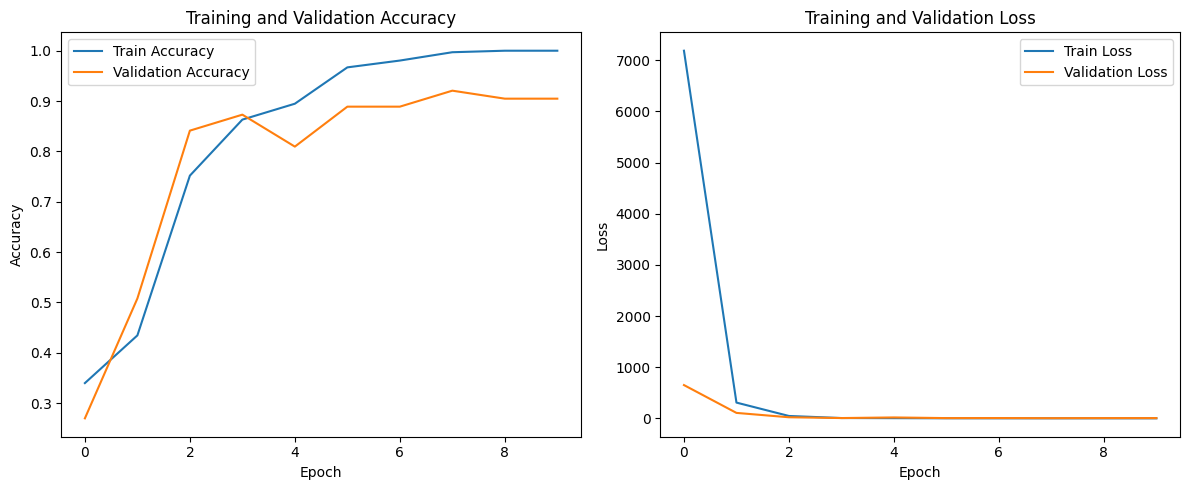

In [5]:
import matplotlib.pyplot as plt

# Memvisualisasikan hasil pelatihan
def plot_training_history(history):
    # Plot akurasi
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk menampilkan plot
plot_training_history(history)

In [ ]:
import tensorflow as tf
import cv2
import numpy as np

# Fungsi untuk memuat model .h5
def load_h5_model(h5_path):
    model = tf.keras.models.load_model(h5_path)
    return model

# Fungsi untuk melakukan preprocessing pada gambar
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Gambar tidak dapat dibaca dari path: {image_path}")
    img = cv2.resize(img, (256, 256))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Fungsi untuk menjalankan prediksi menggunakan model .h5
def predict_image(h5_model_path, image_path, label_map):
    # Memuat model .h5
    model = load_h5_model(h5_model_path)

    # Preprocessing gambar
    input_data = preprocess_image(image_path)

    # Jalankan prediksi
    output_data = model.predict(input_data)
    predicted_label = np.argmax(output_data)
    confidence = np.max(output_data)

    # Tampilkan hasil
    label_name = [k for k, v in label_map.items() if v == predicted_label][0]
    print(f"Prediksi: {label_name} (Confidence: {confidence:.2f})")

In [51]:

# Label mapping (sama dengan yang digunakan saat melatih model)
label_map = {'document': 0, 'KTP': 1, 'KK': 2, 'SIM': 3}

# Path model .h5 dan gambar
h5_model_path = "model_klasifikasi.h5"  # Ganti dengan path model Anda
image_path = "./dataset/test/IMG-20221219-WA0048_jpg.rf.4d90fad32af2a050d70bd3e9f6ee65dc.jpg"  # Ganti dengan path gambar yang ingin diuji

# Jalankan prediksi
predict_image(h5_model_path, image_path, label_map)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Prediksi: KTP (Confidence: 0.85)
